In [923]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import ipywidgets as widgets
import collections

from IPython.display import display
from IPython.display import clear_output

In [924]:
class Spremnik:
    def __init__(self):
        self.container = np.array([], dtype=int) 
    
    def front(self):
        return self.container[0]
    
    def pop(self):
        val = self.container[0]
        self.container = np.delete(self.container, 0)
        return val
    
    def size(self):
        return self.q.size
    
    def empty(self):
        return self.container.size == 0
    
    def flip(self):
        self.container = np.flip(self.container)
        return self
    
    def isin(self, val):
        return np.any(np.isin(self.container, val))
    
    # vraca string, treba mi za print(class) poziv
    def __str__(self):
        return str(self.container)
    
    # za koristenje len(class)
    def __len__(self):
        return self.container.size
    
    # za koristenje display(class)
    def __repr__(self):
        return str(self.container)
    
class Queue(Spremnik):
    def push(self, val):      
        self.container = np.insert(self.container, len(self.container), val)
        
class Stack(Spremnik):
    def push(self, val):
        self.container = np.insert(self.container, 0, val)

In [925]:
class PriorityQueue():
    def __init__(self): 
        self.keys = np.array([], dtype=int) 
        self.values = np.array([], dtype=int)
        
    def sort(self):
        mask = self.values.argsort()
        
        self.keys = self.keys[mask]
        self.values = self.values[mask]
    
    def empty(self):
        return self.keys.size == 0
    
    def pop(self):
        key = self.keys[0]
        value = self.values[0]
        
        self.keys = np.delete(self.keys, 0)
        self.values = np.delete(self.values, 0)
        return key, value
    
    def push(self, val):
        self.keys = np.insert(self.keys, 0, val[0])
        self.values = np.insert(self.values, 0, val[1])
        
        self.sort()
    
    def isin(self, val):
        return np.any(np.isin(self.keys, val))
    
    def set(self, key, val):
        if self.isin(key) == False:
            print("Element s ključem ", key, " ne postoji!")
            return
        
        pos = np.where(self.keys == key)[0][0]
        
        self.values[pos] = val
        self.sort()
    
    # vraca string, treba mi za print(class) poziv
    def __str__(self):
        return str(np.vstack((self.keys, self.values)))
    
    # za koristenje display(class)
    def __repr__(self):
        return str(np.vstack((self.keys, self.values)))

In [926]:
def dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    q = Stack()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        q.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    q.push(trenutni_cvor)
    
    return q

In [927]:
# 1  procedure BFS(G, start_v) is
# 2      let Q be a queue
# 3      label start_v as discovered
# 4      Q.enqueue(start_v)
# 5      while Q is not empty do
# 6          v := Q.dequeue()
# 7          if v is the goal then
# 8              return v
# 9          for all edges from v to w in G.adjacentEdges(v) do
# 10             if w is not labeled as discovered then
# 11                 label w as discovered
# 12                 w.parent := v
# 13                 Q.enqueue(w)

def BFS(G, pocetni_cvor, ciljni_cvor):
    q = Queue()
    q.push(pocetni_cvor)

    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    posjeceni_cvorovi[pocetni_cvor] = True
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    put_obilaska_stabla = Stack()
    
    df = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'red', 'lista_posjecenih'])
    df = df.append(pd.Series(['-', '-', str(q), '-'], index=df.columns ), ignore_index=True)
    
    while q.empty() == False:
        trenutni_cvor = q.pop()
        
        if trenutni_cvor == ciljni_cvor:
            put_obilaska_stabla.push(trenutni_cvor)
            
            df = df.append(pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=df.columns ), ignore_index=True)
            
            return { 'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                     'put_obilaska' : put_obilaska_stabla.flip(),
                     'tablica' : df
                   }

        for susjedni_cvor in sorted(G[trenutni_cvor]):
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

        #ako vec nismo bili u tom cvoru
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(G[trenutni_cvor])), str(trenutni_cvor), str(q), str(put_obilaska_stabla)], index=df.columns) 
            df = df.append(red, ignore_index=True)

In [928]:
# procedure DFS-iterative(G, v) is
#     let S be a stack
#     S.push(v)
#     while S is not empty do
#         v = S.pop()
#         if v is not labeled as discovered then
#             label v as discovered
#             for all edges from v to w in G.adjacentEdges(v) do 
#                 S.push(w)

def DFS(G, pocetni_cvor, ciljni_cvor):
    s = Stack()
    s.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;
    
    put_obilaska_stabla = Stack()
    
    #dodajemo podatke u tablicu
    df = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'stog', 'lista_posjecenih'])
    df = df.append(pd.Series(['-', '-', str(s), '-'], index=df.columns ), ignore_index=True)
    
    while s.empty() == False:
        trenutni_cvor = s.pop()
        
        if trenutni_cvor == ciljni_cvor:
            put_obilaska_stabla.push(trenutni_cvor)
            
            df = df.append(pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=df.columns ), ignore_index=True)
            
            return {'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                    'put_obilaska' : put_obilaska_stabla.flip(),
                    'tablica' : df
                   }
        
        if posjeceni_cvorovi[trenutni_cvor] == False:
            posjeceni_cvorovi[trenutni_cvor] = True
            
            for susjedni_cvor in sorted(G[trenutni_cvor], reverse = True):
                 if posjeceni_cvorovi[susjedni_cvor] == False:
                    roditelj_cvora[susjedni_cvor] = trenutni_cvor
                    s.push(susjedni_cvor)

        #ako vec nismo bili u tom cvoru
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(G[trenutni_cvor])), str(trenutni_cvor), str(s), str(put_obilaska_stabla)], index=df.columns) 
            df = df.append(red, ignore_index=True)

In [929]:
broj_cvorova = 10
pocetni_cvor = 1
ciljni_cvor = 4

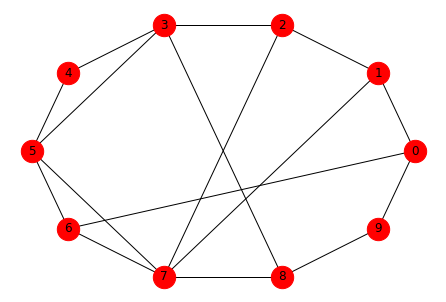

In [930]:
# s ovim generiram random povezan graf
G = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

pos_G = nx.shell_layout(G)
nx.draw(G, pos_G, node_size=500, with_labels=True, node_color='red')

In [931]:
def ispisi_output_1():
    
    clear_output(wait=True)
    
    display(HBox_1, output_1)

    for index, ime_algoritma in enumerate(imena_algoritama):
        node_colors[ime_algoritma] = [node_colors_map[ime_algoritma][node] for node in G.nodes()]

        display(tablice[ime_algoritma].head(brojac))
        
        plt.subplot(1, len(imena_algoritama), index + 1)   
        nx.draw(G, pos_G, node_size=300, with_labels=True, node_color=node_colors[ime_algoritma])

def promjeni_boju_cvora(put_1, put_2, colors_map, boja):
    
    if put_1.empty() == False:
            put_2.push(put_1.pop())
            colors_map[put_2.front()] = boja;
    
def sljedeci_1_clicked(b):
    global brojac
    global max_brojac
    
    for ime_algoritma in imena_algoritama:
        promjeni_boju_cvora(putevi[ime_algoritma], pokazane_tocke[ime_algoritma], 
                            node_colors_map[ime_algoritma], 'yellow'
                            )
    brojac = min(brojac + 1, max_brojac)
        
    ispisi_output_1()
        
def prethodni_1_clicked(b):
    global brojac
    
    for ime_algoritma in imena_algoritama:
        promjeni_boju_cvora(pokazane_tocke[ime_algoritma], putevi[ime_algoritma],
                            node_colors_map[ime_algoritma], 'red'
                            )
    brojac = max(0, brojac - 1)
        
    ispisi_output_1()

Output()

,susjedi,trenutni cvor,red,lista_posjecenih
0,-,-,[1],-
1,"[0, 2, 7]",1,[0 2 7],[1]
2,"[1, 6, 9]",0,[2 7 6 9],[0 1]
3,"[1, 3, 7]",2,[7 6 9 3],[2 0 1]


,susjedi,trenutni cvor,stog,lista_posjecenih
0,-,-,[1],-
1,"[0, 2, 7]",1,[0 2 7],[1]
2,"[1, 6, 9]",0,[6 9 2 7],[0 1]
3,"[0, 5, 7]",6,[5 7 9 2 7],[6 0 1]


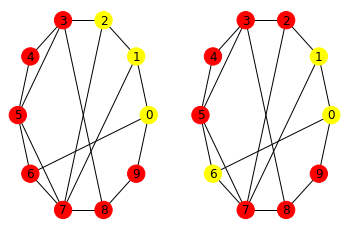

In [932]:
# definiramo gumbe
sljedeci_1 = widgets.Button(description=">")
prethodni_1 = widgets.Button(description="<")
output_1 = widgets.Output()
HBox_1 = widgets.HBox([prethodni_1, sljedeci_1])

sljedeci_1.on_click(sljedeci_1_clicked)
prethodni_1.on_click(prethodni_1_clicked)

# za dodat novi algoritam samo dodati ime i u varijablu put dodati pripadnu funkciju
imena_algoritama = ['BFS', 'DFS']
vrsta = 'put_obilaska'

pokazane_tocke = { ime_algoritma : Stack() for ime_algoritma in imena_algoritama }
putevi = { 'BFS' : BFS(G, pocetni_cvor, ciljni_cvor)[vrsta], 
           'DFS' : DFS(G, pocetni_cvor, ciljni_cvor)[vrsta]
         }
tablice = { 'BFS' : BFS(G, pocetni_cvor, ciljni_cvor)['tablica'], 
           'DFS' : DFS(G, pocetni_cvor, ciljni_cvor)['tablica']
          }

# brojac za ispisivanje tablice
brojac = 1
max_brojac = max(len(putevi['BFS']), len(putevi['DFS'])) + 1

# dictionary s bojama za svaki nod
node_colors_map = { ime_algoritma : { i : 'red' for i in range(len(G)) } for ime_algoritma in imena_algoritama }

# niz odgovarajucih boja
node_colors = { ime_algoritma : [node_colors_map[ime_algoritma][node] for node in G.nodes()] 
               for ime_algoritma in imena_algoritama 
              }

ispisi_output_1()

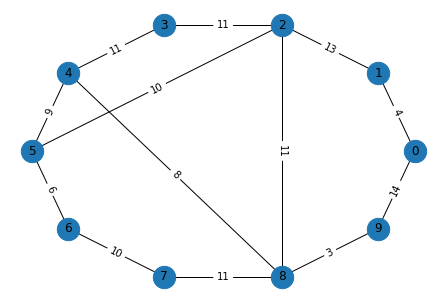

In [933]:
#weights = [ np.random.randint(1,10) for i in range(len(G.edges))]

H = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 2, 0.4, np.random.randint(10000))

for (u, v, w) in H.edges(data=True):
    w['weight'] = np.random.randint(1, 15)

pos_H = nx.shell_layout(H)
nx.draw(H, pos_H, node_size=500, with_labels=True)

weights = nx.get_edge_attributes(H,'weight')
nx.draw_networkx_edge_labels(H, pos_H, edge_labels=weights);

In [934]:
# 1  function Dijkstra(Graph, source):
# 2      dist[source] ← 0                           // Initialization
# 3
# 4      create vertex priority queue Q
# 5
# 6      for each vertex v in Graph:           
# 7          if v ≠ source
# 8              dist[v] ← INFINITY                 // Unknown distance from source to v
# 9              prev[v] ← UNDEFINED                // Predecessor of v
# 10
# 11         Q.add_with_priority(v, dist[v])
# 12
# 13
# 14     while Q is not empty:                      // The main loop
# 15         u ← Q.extract_min()                    // Remove and return best vertex
# 16         for each neighbor v of u:              // only v that are still in Q
# 17             alt ← dist[u] + length(u, v) 
# 18             if alt < dist[v]
# 19                 dist[v] ← alt
# 20                 prev[v] ← u
# 21                 Q.decrease_priority(v, alt)
# 22
# 23     return dist, prev

In [978]:
# brojac dodan da mogu izmedu koraka ici (ne bas najpametnije rjesenje)
def Dijkstra(G, pocetni_cvor, brojac=99999):
    udaljenosti = np.zeros(len(G), dtype=int)
    roditelj_cvora = np.zeros(len(G), dtype=int)
    posjeceni_cvorovi = np.zeros(len(G), dtype=bool)
    
    q = PriorityQueue()
    q.push((pocetni_cvor, 0))
    
    weights = nx.get_edge_attributes(H,'weight')
    
    df = pd.DataFrame([], columns=['cvor', 'posjeceni', 'cijene', 'put'])
    
    for cvor in G.nodes:
        if cvor != pocetni_cvor:
            # promjeni ovo kasnije
            udaljenosti[cvor] = 99999
            roditelj_cvora[cvor] = -1
            
            q.push((cvor, udaljenosti[cvor]))
            
        red = pd.Series([cvor, posjeceni_cvorovi[cvor], udaljenosti[cvor], roditelj_cvora[cvor]], 
                        index=df.columns 
                       )
        df = df.append(red, ignore_index=True)    
    
    while q.empty() == False and brojac != 0:
        trenutni_cvor, value = q.pop()
        
        posjeceni_cvorovi[trenutni_cvor] = True
        
        # postavimo u tablici da je cvor posjecen
        df['posjeceni'][trenutni_cvor] = posjeceni_cvorovi[trenutni_cvor]
        
        for susjedni_cvor in sorted(H[trenutni_cvor]):
            
            u = min(trenutni_cvor, susjedni_cvor)
            v = max(trenutni_cvor, susjedni_cvor)
            
            nova_udaljenost = udaljenosti[trenutni_cvor] + weights[u, v]
            if nova_udaljenost < udaljenosti[susjedni_cvor]:
                
                udaljenosti[susjedni_cvor] = nova_udaljenost
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                
                df['cijene'][susjedni_cvor] = udaljenosti[susjedni_cvor]
                df['put'][susjedni_cvor] = roditelj_cvora[trenutni_cvor]
                
                q.set(susjedni_cvor, nova_udaljenost)
            
        brojac = brojac - 1
            
    return {'udaljenosti' : udaljenosti, 
            'roditelj_cvora' : roditelj_cvora, 
            'tablica' : df 
           }


In [983]:
def ispisi_output_2():
    clear_output(wait=True)
    
    display(HBox_2, output_2)
    
    dijkstra = Dijkstra(H, 0, brojac_2)
    display(dijkstra['tablica'])
    
    cijene = dijkstra['tablica']['cijene']
    labels_map = { i : cijene[i] for i in range(len(H)) }
    
    colors = ['yellow', 'red']
    posjeceni = dijkstra['tablica']['posjeceni']
    node_colors = [ colors[int(posjeceni[i])] for i in range(len(H))]
    
    pos_H = nx.shell_layout(H)
    nx.draw(H, pos_H, node_size=500, with_labels=True, labels=labels_map, node_color=node_colors)

    weights = nx.get_edge_attributes(H,'weight')
    nx.draw_networkx_edge_labels(H, pos_H, edge_labels=weights);

def sljedeci_2_clicked(b):
    global brojac_2
    
    brojac_2 = min(brojac_2 + 1, len(H))
        
    ispisi_output_2()
        
def prethodni_2_clicked(b):
    global brojac_2
        
    brojac_2 = max(0, brojac_2 - 1)
        
    ispisi_output_2()

Output()

,cvor,posjeceni,cijene,put
0,0,False,0,0
1,1,False,99999,-1
2,2,False,99999,-1
3,3,False,99999,-1
4,4,False,99999,-1
5,5,False,99999,-1
6,6,False,99999,-1
7,7,False,99999,-1
8,8,False,99999,-1
9,9,False,99999,-1


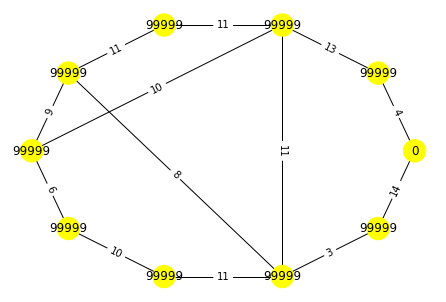

In [985]:
# definiramo gumbe
sljedeci_2 = widgets.Button(description=">")
prethodni_2 = widgets.Button(description="<")
output_2 = widgets.Output()
HBox_2 = widgets.HBox([prethodni_2, sljedeci_2])

sljedeci_2.on_click(sljedeci_2_clicked)
prethodni_2.on_click(prethodni_2_clicked)

brojac_2 = 0;

ispisi_output_2()